In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from tensorflow import keras
import time

In [2]:
import importlib
# import helper.series

In [3]:
# importlib.reload(helper.series)

In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
matplotlib 3.0.3
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [5]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Dataset

In [183]:
def generate_time_series(batch_size, n_in, n_out):
    t = np.arange(n_in + n_out)
    series = np.zeros((batch_size, n_in + n_out))
    series += 0.1 * (np.random.normal(0, 0.5, (batch_size, n_in + n_out)))  # + noise
    series[:, -n_out:] += (np.arange(n_out)) * 0.05
    sign = (np.random.choice([-1, 1], batch_size, p=[0.35, 0.65]))
    series[:, -n_out:] *= sign[..., np.newaxis]
    return series[..., np.newaxis].astype(np.float32)

In [184]:
np.random.seed(42)

n_in = 30
series = generate_time_series(5000, n_in = 30, n_out = 10)
print(series.shape)
X_train, Y_train = series[:3000, :n_in], series[:3000, n_in:]
X_valid, Y_valid = series[3000:4000, :n_in], series[3000:4000, n_in:]
X_test, Y_test = series[4000:, :n_in], series[4000:, n_in:]
Y_train = np.squeeze(Y_train)
Y_valid = np.squeeze(Y_valid)
Y_test = np.squeeze(Y_test)

(5000, 40, 1)


In [185]:
X_train.shape, Y_train.shape

((3000, 30, 1), (3000, 10))

In [186]:
def plot_multiple_forecasts(X, Y, Y_pred=None, title=""):
    n_in = X.shape[1]
    n_out = Y.shape[1]
    fig= plt.figure(figsize=(10,6))
    plt.xlabel("$t$", fontsize=16)
    plt.ylabel("$x(t)$", fontsize=16)
    plt.title(title, fontsize=16)
    for i in range(20):
        plt.plot(X[i, :, 0])
        plt.plot(np.arange(n_in, n_in + n_out), Y[i, :], "x-")
        if(Y_pred is not None):
            plt.plot(np.arange(n_in, n_in + n_out), Y_pred[i, :], "+-", markersize=10)

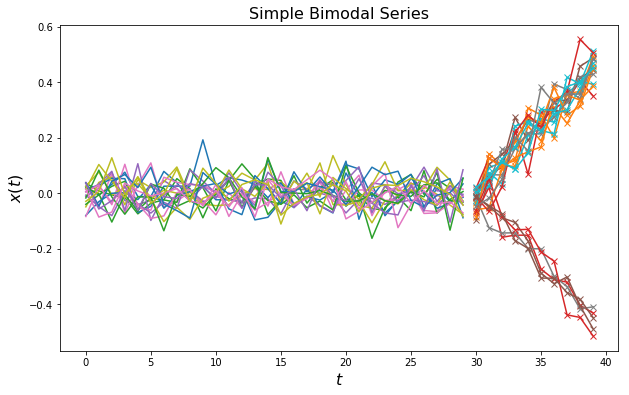

In [187]:
plot_multiple_forecasts(X_train, Y_train, Y_pred=None, title="Simple Bimodal Series")
plt.show()

# Testing Simple Model

In [188]:
def simple_conv_and_lstm_layout(window_size, targetsize):  
    """
    Define a simple LSTM layout
    """    
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=[window_size, 1]), 
        keras.layers.LSTM(20, return_sequences=False), # for simpler Y_valid we don't use return_sequences=True here
        keras.layers.Dense(targetsize)
    ])
    return model

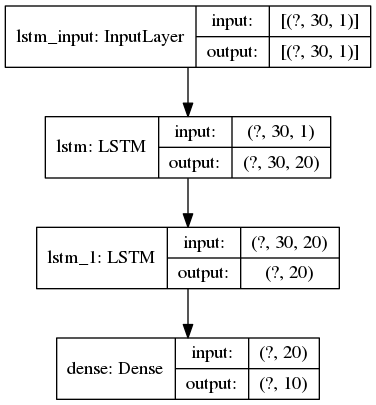

In [189]:
model_lstm_ts10 = simple_conv_and_lstm_layout(window_size=30, targetsize=10)
keras.utils.plot_model(model_lstm_ts10, "model.png", show_shapes=True)

In [190]:
optimizer = keras.optimizers.Adam(lr=0.001)
model_lstm_ts10.compile(loss="mse", optimizer=optimizer)
history = model_lstm_ts10.fit(X_train, Y_train, epochs=3,
                    validation_data=(X_valid, Y_valid))

Train on 3000 samples, validate on 1000 samples
Epoch 1/3
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.0682 - val_loss: 0.0657
Epoch 2/3
3000/3000 [==============================] - 5s 2ms/sample - loss: 0.0673 - val_loss: 0.0655
Epoch 3/3
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.0673 - val_loss: 0.0655


In [191]:
model_lstm_ts10.evaluate(X_test, Y_test)

1000/1000 [==============================] - 0s 315us/sample - loss: 0.0634


0.06337230983376503

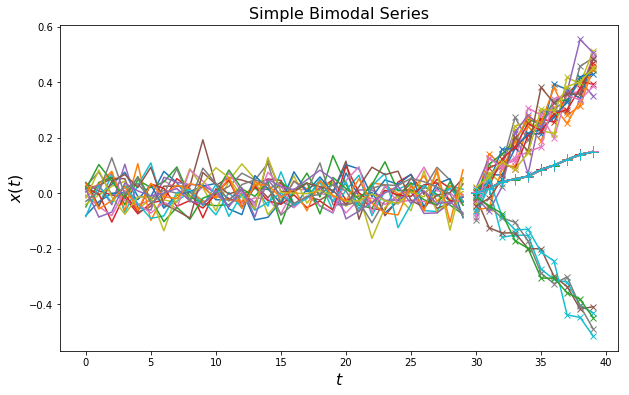

In [192]:
Y_pred = model_lstm_ts10.predict(X_test)
plot_multiple_forecasts(X_train, Y_train, Y_pred, title="Simple Bimodal Series")
plt.show()

In [193]:
nd_test = tfd.Normal(loc=np.mean(Y_test[:,5]), scale=np.std(Y_test[:,5]))

In [194]:
print(np.mean(Y_test[:,5]))
print(np.std(Y_test[:,5]))

0.09380316
0.23473465


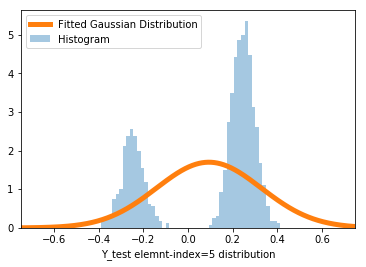

In [195]:
lower = -0.75
upper = 0.75

f = plt.figure()
ax = plt.gca()
sns.distplot(Y_test[:,5], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")

ax.set_xlabel("Y_test elemnt-index=5 distribution")
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, nd_test.prob(x).numpy(), lw=5, label="Fitted Gaussian Distribution")
_ = ax.legend()

In [196]:
Y_test_neg_5 = Y_test[:, 5][Y_test[:, 5] < 0]
Y_test_pos_5 = Y_test[:, 5][Y_test[:, 5] >= 0]

In [197]:
print(np.mean(Y_test_neg_5))
print(np.mean(Y_test_pos_5))
print(np.std(Y_test_neg_5))
print(np.std(Y_test_pos_5))

-0.24779344
0.2472741
0.051770695
0.05170076


In [198]:
alphas = [Y_test_neg_5.shape[0], Y_test_pos_5.shape[0]]
means = [np.mean(Y_test_neg_5), np.mean(Y_test_pos_5)]
sigmas = [np.std(Y_test_neg_5), np.std(Y_test_pos_5)]

gm_test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(
        loc=means,       
        scale=sigmas))

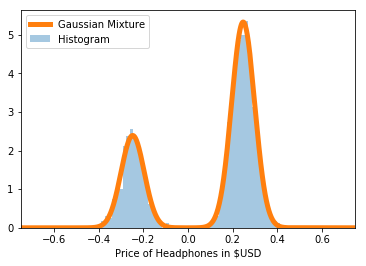

In [199]:
f = plt.figure()
ax = plt.gca()
sns.distplot(Y_test[:,5], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")

ax.set_xlabel('Price of Headphones in $USD')
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, gm_test.prob(x).numpy(), lw=5, label="Gaussian Mixture")
_ = ax.legend()

In [235]:
num_components = 3    # Number of components in the mixture
event_shape = [10]
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
print(params_size)

63


In [236]:
inputs = keras.layers.Input(shape=(30, 1))
h1 = keras.layers.LSTM(20, return_sequences=True)(inputs)
h2 = keras.layers.LSTM(params_size, return_sequences=False, activation=None)(h1) # !!! activation None
dl = tfp.layers.MixtureNormal(num_components, event_shape)(h2)

model_mx = keras.models.Model(inputs=[inputs], outputs=[dl])

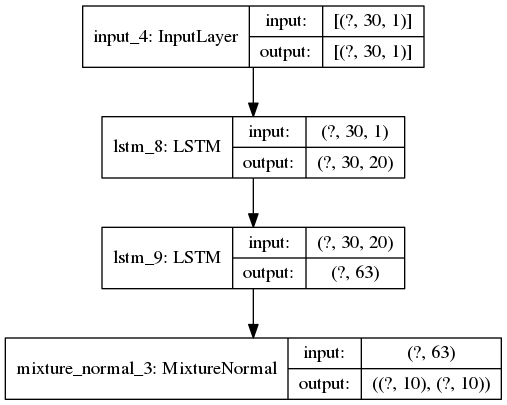

In [237]:
keras.utils.plot_model(model_mx, "model.png", show_shapes=True)

In [238]:
# negloglik = lambda y, rv_y: -rv_y.log_prob(y)

def negloglik(y, rv_y):
    return tf.reduce_mean(-rv_y.log_prob(y), axis=-1)  

In [239]:
optimizer = keras.optimizers.Adam(lr=0.001)
model_mx.compile(loss=negloglik, optimizer=optimizer)
history = model_mx.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/sample - loss: 5.2371 - val_loss: 5.7073
Epoch 2/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 5.6261 - val_loss: 5.4754
Epoch 3/20
3000/3000 [==============================] - 6s 2ms/sample - loss: 4.9315 - val_loss: 2.2962
Epoch 4/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -0.4178 - val_loss: -7.1277
Epoch 5/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -2.6673 - val_loss: 3.2481
Epoch 6/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -8.0912 - val_loss: -12.6205
Epoch 7/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -12.4737 - val_loss: -13.4722
Epoch 8/20
3000/3000 [==============================] - 6s 2ms/sample - loss: -12.2891 - val_loss: -13.1583
Epoch 9/20
3000/3000 [==============================] - 7s 2ms/sample - loss: -13.2004 - val_loss: -13.33

In [240]:
yhat = model_mx(X_test[:1,:,:])
assert isinstance(yhat, tfd.Distribution)

In [241]:
yhat.submodules

(<tfp.distributions.Independent 'model_3_mixture_normal_3_MixtureSameFamily_independent_normal_2_IndependentNormal_Independentmodel_3_mixture_normal_3_MixtureSameFamily_independent_normal_2_IndependentNormal_Normal' batch_shape=[1, 3] event_shape=[10] dtype=float32>,
 <tfp.distributions.Categorical 'model_3_mixture_normal_3_MixtureSameFamily_Categorical' batch_shape=[1] event_shape=[] dtype=int32>,
 <tfp.distributions.Normal 'model_3_mixture_normal_3_MixtureSameFamily_independent_normal_2_IndependentNormal_Normal' batch_shape=[1, 3, 10] event_shape=[] dtype=float32>)

In [242]:
yhat_means = yhat.submodules[2].mean().numpy()
print(yhat_means.shape)
print(yhat_means[:,:,5])

(1, 3, 10)
[[ 0.2698236  -0.26054394  0.08917724]]


In [243]:
yhat_cw = yhat.submodules[1].probs_parameter().numpy()
print(yhat_cw.shape)
print(yhat_cw)

(1, 3)
[[0.64515424 0.3481365  0.00670919]]


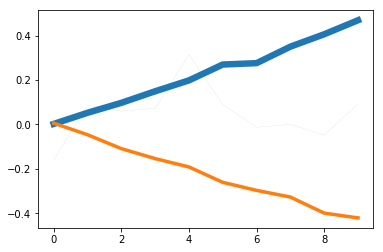

In [244]:
plt.plot(yhat_means[0,0,:], linewidth=yhat_cw[0,0]*10)
plt.plot(yhat_means[0,1,:], linewidth=yhat_cw[0,1]*10)
plt.plot(yhat_means[0,2,:], linewidth=yhat_cw[0,2]*10)

In [245]:
yhat_stddev = yhat.submodules[2].stddev().numpy()
yhat_stddev[:,:,5]

array([[0.04615075, 0.04857223, 0.49670848]], dtype=float32)

In [246]:
yhat.submodules[0].distribution.mean()

<tf.Tensor: shape=(1, 3, 10), dtype=float32, numpy=
array([[[ 2.38466798e-03,  5.24540842e-02,  9.72990021e-02,
          1.49384931e-01,  1.98396072e-01,  2.69823611e-01,
          2.76065886e-01,  3.50297987e-01,  4.06095088e-01,
          4.69180584e-01],
        [ 5.83401043e-03, -4.61120084e-02, -1.08708605e-01,
         -1.53606519e-01, -1.91199243e-01, -2.60543942e-01,
         -2.96660155e-01, -3.26841980e-01, -3.99088889e-01,
         -4.20662880e-01],
        [-1.59524336e-01,  8.69464427e-02,  5.99276982e-02,
          7.27945417e-02,  3.13935727e-01,  8.91772434e-02,
         -1.24885635e-02,  3.49391572e-04, -4.74709906e-02,
          9.31942388e-02]]], dtype=float32)>

In [247]:
gm_test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=yhat_cw[0]),
    components_distribution=tfd.Normal(
        loc=yhat_means[0,:,5],       
        scale=yhat_stddev[0,:,5]))

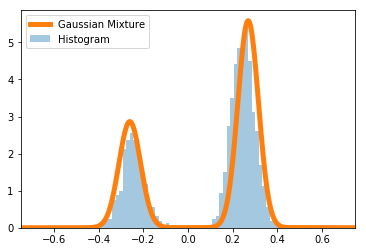

In [248]:
f = plt.figure()
ax = plt.gca()
sns.distplot(Y_test[:,5], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")
ax.set_xlim(lower, upper)

x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
ax.plot(x, gm_test.prob(x).numpy(), lw=5, label="Gaussian Mixture")
_ = ax.legend()

In [51]:
smpl = yhat.sample(10000)
print(smpl.shape)

(10000, 1, 10)


In [54]:
smpl[0]

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.10916712, -0.21589583,  0.03231663, -0.14085717,  0.49457198,
        -0.26968628, -0.46157044, -0.14725359, -0.07499   , -0.46625802]],
      dtype=float32)>

(-0.75, 0.75)

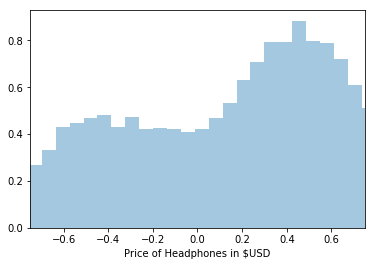

In [56]:
f = plt.figure()
ax = plt.gca()
sns.distplot(smpl[:,:,9], bins=50, kde=False, norm_hist=True, ax=ax, label="Histogram")

ax.set_xlabel('Price of Headphones in $USD')
ax.set_xlim(lower, upper)

# x = np.linspace(upper, lower, int(1e4), dtype=np.float32)
# ax.plot(x, gm_test.prob(x).numpy(), lw=5, label="Gaussian Mixture")
# _ = ax.legend()

In [142]:
def learning_rate_finder(model, X, Y):  
    """
    Goes trough learning rates and gives back the history object
    to find optimal learning rate.
    """
    # check learning rates to find the best
    lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=negloglik,
                optimizer=optimizer,
                metrics=["mae"])
    # get history to find the best learning rate
    return model.fit(X, Y, epochs=100, callbacks=[lr_schedule])

In [143]:
def lr_loss_chart(finder_history, xmin, xmax, ymin, ymax):  
    # plot the learning rate / loss chart
    # the best learning rates are around the lowest smooth part of the curve
    plt.semilogx(finder_history.history["lr"], finder_history.history["loss"])
    plt.axis([xmin, xmax, ymin, ymax])

Train on 3000 samples
Epoch 1/100
3000/3000 [==============================] - 11s 4ms/sample - loss: -1.6257 - mae: 0.3738
Epoch 2/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3693
Epoch 3/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3772
Epoch 4/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3718
Epoch 5/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3726
Epoch 6/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3712
Epoch 7/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3705
Epoch 8/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3690
Epoch 9/100
3000/3000 [==============================] - 6s 2ms/sample - loss: -1.6257 - mae: 0.3700
Epoch 10/100
3000/3000 [==============================] - 6s 2ms/sam

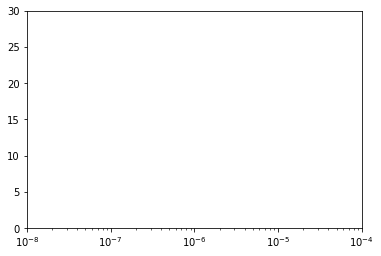

In [145]:
lr_loss_chart(learning_rate_finder(model_mx, X_train, Y_train), 1e-8, 1e-4, 0, 30)

In [134]:
def model_trainer(model, lr, train_set, valid_set, checkpoint_name):
    """
    Builds and traines simple lstm network.
    Returns the history object
    """
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9) # use best learning rate estimation
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    model_checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_name, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=50)
    return model.fit(train_set, epochs=5000,
            validation_data=valid_set,
            callbacks=[early_stopping, model_checkpoint])

In [135]:
model_mx = simple_conv_and_lstm_layout(window_size = 30, targetsize=10)

In [ ]:
keras.utils.plot_model(model_lstm_ts10, "model.png", show_shapes=True)

In [ ]:
def lr_loss_chart(finder_history, xmin, xmax, ymin, ymax):  
    # plot the learning rate / loss chart
    # the best learning rates are around the lowest smooth part of the curve
    plt.semilogx(finder_history.history["lr"], finder_history.history["loss"])
    plt.axis([xmin, xmax, ymin, ymax])

In [ ]:
lr_loss_chart(learning_rate_finder(model_lstm_ts1, train_set=X_train), 1e-8, 1e-4, 0, 30)